In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.model_selection import GridSearchCV
from copy import deepcopy

# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


Data array:  (11, 2)
Features (11, 1)
25


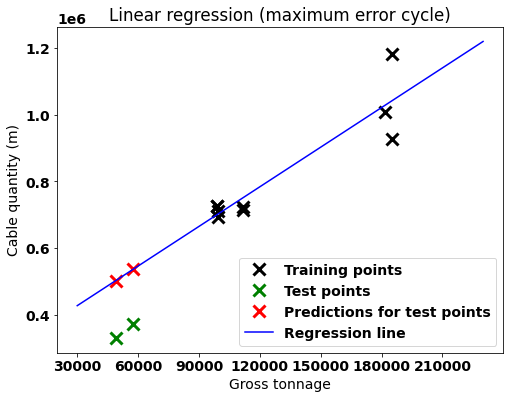

In [2]:
# Whole ship cable quantities
# Predictors:
# GT
# Algorithms:
# Linear regression
# KNN regression
# Mean

plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'

# Get the data
cursor.execute("SELECT gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " WHERE running LIKE 'Y%'"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
print('Data array: ', data.shape)
X = data[:, 0].reshape((-1, 1))
print('Features', X.shape)
y = data[:, -1]


# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# init regression model
models = dict()
models['Linear regression'] = linear_model.LinearRegression()
#models['KNN Regression'] = KNeighborsRegressor()
#models['Mean'] = DummyRegressor(strategy='mean')

scaler = pp.MinMaxScaler()

# train and evaluate all models with lpo
table_rows = [['Model', 'mean', 'std', 'min', 'max']]
plt.figure(figsize=(8, 6))
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(X):
        if model_name == 'KNN Regression':
            clf = GridSearchCV(model, {'n_neighbors':[1, 3, 5], 'weights': ['uniform', 'distance']}, cv=3)
            X_train = deepcopy(scaler.fit_transform(X[train_i]))
            clf.fit(X_train, y[train_i], )
            X_test = deepcopy(scaler.transform(X[test_i])) #normalize features
            preds = clf.predict(X_test)
            scores.append(mape(y[test_i], preds))
            if len(scores) == 26:
                print(model.n_neighbors)
                plt.plot(X[train_i], y[train_i], 'kx', markersize=12, mew=3)
                plt.plot(X[test_i], y[test_i], 'gx',  markersize=12, mew=3)
                plt.plot(X[test_i], preds, 'rx', markersize=12, mew=3)
                x = np.linspace(30000, 230000, 10)
                plt.scatter([99526], preds[0], s=5000, facecolors='none', edgecolors='r')
                plt.text(71526, preds[0]+300000, "Nearest points, k = 5")
                plt.xlabel('Gross tonnage')
                plt.ylabel('Cable quantity (m)')
                plt.legend(['Training points', 'Test points', 'Predictions for test points'])
                plt.xticks(np.arange(min(x), max(x)+1, 30000))
                #plt.title("KNN regression (maximum error cycle)")
                plt.savefig('knn_worst_case.png')
        else:
            model.fit(X[train_i], y[train_i])
            preds = model.predict(X[test_i])
            scores.append(mape(y[test_i], preds))
            if len(scores) == 26:
                plt.plot(X[train_i], y[train_i], 'kx', markersize=12, mew=3)
                plt.plot(X[test_i], y[test_i], 'gx',  markersize=12, mew=3)
                plt.plot(X[test_i], preds, 'rx', markersize=12, mew=3)
                x = np.linspace(30000, 230000, 10)
                plt.plot(x, model.coef_[0]*x + model.intercept_, 'b')
                plt.xlabel('Gross tonnage')
                plt.ylabel('Cable quantity (m)')
                plt.legend(['Training points', 'Test points', 'Predictions for test points', 'Regression line'])
                plt.xticks(np.arange(min(x), max(x)+1, 30000))
                plt.title("Linear regression (maximum error cycle)")
                #plt.savefig('linear_worst_case.png')

    scores = np.array(scores)
    print(np.argmax(scores))
    table_rows.append((model_name, scores.mean(), scores.std(), scores.min(), scores.max()))
    with open("static_whole_ship_cable_quantities.txt", "a") as file_object:
        if model_name == 'Mean':
            line = '-;Whole ship cable quantity;m;{};{};{};{};{}\n'.format(model_name, scores.mean(), scores.std(), scores.min(), scores.max())
        else:
            line = 'GT;Whole ship cable quantity;m;{};{};{};{};{}\n'.format(model_name, scores.mean(), scores.std(), scores.min(), scores.max())
        file_object.write(line)
display_table(table_rows)


In [2]:
# Whole ship cable quantities
# Predictors:
# Ship squares
# Algorithms:
# Linear regression
# KNN regression

# Get the data
cursor.execute("SELECT ship_squares , sum(amount) FROM routed as r"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON a.project_id=r.project_id"
    " GROUP BY r.project_id, ship_squares")
data = np.array(cursor.fetchall()).astype('float32')
print('Data array: ', data.shape)
X = data[:, 0].reshape((-1, 1))
print('Features', X.shape)
y = data[:, -1]


# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# init regression model
models = dict()
models['Linear regression'] = linear_model.LinearRegression()
models['KNN Regression'] = KNeighborsRegressor()

scaler = pp.MinMaxScaler()

# train and evaluate all models with lpo
table_rows = [['Model', 'mean', 'std', 'min', 'max']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(X):
        if model_name == 'KNN Regression':
            clf = GridSearchCV(model, {'n_neighbors':[1, 3, 5], 'weights': ['uniform', 'distance']}, cv=3)
            X_train = scaler.fit_transform(X[train_i])
            clf.fit(X_train, y[train_i])
            #print(clf.best_params_)
            X_test = scaler.transform(X[test_i]) #normalize features
            preds = clf.predict(X_test)
            scores.append(mape(y[test_i], preds))
        else:
            model.fit(X[train_i], y[train_i])
            preds = model.predict(X[test_i])
            scores.append(mape(y[test_i], preds))
    scores = np.array(scores)
    table_rows.append((model_name, scores.mean(), scores.std(), scores.min(), scores.max()))
    with open("static_whole_ship_cable_quantities.txt", "a") as file_object:
        line = 'Ship squares;Whole ship cable quantity;m;{};{};{};{};{}\n'.format(model_name, scores.mean(), scores.std(), scores.min(), scores.max())
        file_object.write(line)
display_table(table_rows)



Data array:  (11, 2)
Features (11, 1)


In [4]:
# Whole ship cable quantities
# Predictors:
# GT
# Ship squares
# Algorithms:
# Linear regression
# KNN regression


# Get the data
cursor.execute("SELECT gross_tonnage, ship_squares, drw_count, sum(amount) FROM routed as r"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON a.project_id=r.project_id"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " LEFT JOIN (SELECT project_id, count(DISTINCT drawing) as drw_count FROM drawing_types GROUP BY project_id) t1 ON t1.project_id=r.project_id"
    " GROUP BY r.project_id, ship_squares, drw_count, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
print('Data array: ', data.shape)
X = data[:, [0, 1, 2]]
print('Features', X.shape)
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# init regression model
models = dict()
models['Linear regression'] = linear_model.LinearRegression()
models['KNN Regression'] = KNeighborsRegressor()

scaler = pp.MinMaxScaler()

# train and evaluate all models with lpo
table_rows = [['Model', 'mean', 'std', 'min', 'max']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(X):
        if model_name == 'KNN Regression':
            clf = GridSearchCV(model, {'n_neighbors':[1, 3, 5], 'weights': ['uniform', 'distance']}, cv=3)
            X_train = scaler.fit_transform(X[train_i])
            clf.fit(X_train, y[train_i])
            #print(clf.best_params_)
            X_test = scaler.transform(X[test_i]) #normalize features
            preds = clf.predict(X_test)
            scores.append(mape(y[test_i], preds))
        else:
            model.fit(X[train_i], y[train_i])
            preds = model.predict(X[test_i])
            scores.append(mape(y[test_i], preds))
    scores = np.array(scores)
    table_rows.append((model_name, scores.mean(), scores.std(), scores.min(), scores.max()))
    with open("static_whole_ship_cable_quantities.txt", "a") as file_object:
        line = 'GT, Ship squares;Whole ship cable quantity;m;{};{};{};{};{}\n'.format(model_name, scores.mean(), scores.std(), scores.min(), scores.max())
        file_object.write(line)
display_table(table_rows)


Data array:  (11, 4)
Features (11, 3)


In [11]:
# Whole ship cable quantities (pcs, for comparison)
# Predictors:
# GT
# Algorithms:
# Linear regression

# Get the data
cursor.execute("SELECT gross_tonnage, count(*) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
print('Data array: ', data.shape)
X = data[:, 0].reshape((-1, 1))
print('Features', X.shape)
y = data[:, -1]


# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# init regression model
models = dict()
models['Linear regression'] = linear_model.LinearRegression()

# train and evaluate all models with lpo
table_rows = [['Model', 'mean', 'std', 'min', 'max']]
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(X):
        model.fit(X[train_i], y[train_i])
        preds = model.predict(X[test_i])
        scores.append(mape(y[test_i], preds))
    scores = np.array(scores)
    table_rows.append((model_name, scores.mean(), scores.std(), scores.min(), scores.max()))
    with open("static_whole_ship_cable_quantities.txt", "a") as file_object:
        line = 'GT;Whole ship cable quantity (for comparison);pcs;{};{};{};{};{}\n'.format(model_name, scores.mean(), scores.std(), scores.min(), scores.max())
        file_object.write(line)
display_table(table_rows)


Data array:  (11, 2)
Features (11, 1)


Data array:  (11, 2)
Features (11, 1)
[[ 4.36056280e-11 -5.06677180e-06]
 [-5.06677180e-06  6.79644483e-01]]
gt: 250000, cables: [3143895.99847412]m +- [553318.08449815]m


<Figure size 576x432 with 0 Axes>

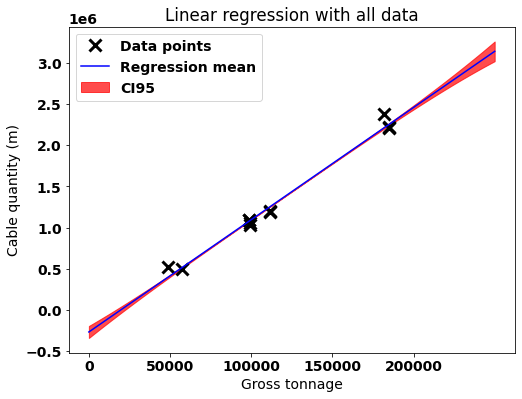

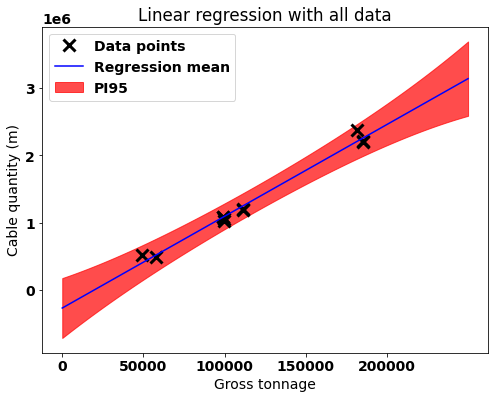

In [93]:
# Whole ship cable quantities
# Predictors:
# GT
# Algorithms:
# Linear regression with confidence intervals


plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'

# Get the data
cursor.execute("SELECT gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
print('Data array: ', data.shape)
X = data[:, 0].reshape((-1, 1))
print('Features', X.shape)
y = data[:, -1]


# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# init regression model
models = dict()
models['Linear regression'] = linear_model.LinearRegression()
#models['KNN Regression'] = KNeighborsRegressor()
#models['Mean'] = DummyRegressor(strategy='mean')

scaler = pp.MinMaxScaler()

# train and evaluate all models with lpo
table_rows = [['Model', 'mean', 'std', 'min', 'max']]
plt.figure(figsize=(8, 6))
for model_name in models.keys():
    model = models[model_name]
    scores = []
    for train_i, test_i in lpo.split(X):
        model.fit(X, y)
        n = X.shape[0]
        X1 = np.append(X, np.ones(n).reshape(n, 1), axis=1)
        B = np.linalg.inv(X1.T @ X1) @ X1.T @ y
        Yhat = X1 @ B

        scores.append(0)

        sigmahat = np.sqrt( np.square(y - X1 @ B).sum()/(n - X1.shape[1]) )
        C = np.linalg.inv(X1.T @ X1)
        print(C)
        n = 100
        x = np.linspace(0, 250001, n).reshape(n, 1)
        x = np.append(x, np.ones(n).reshape(n, 1), axis=1)
        sefit = np.diag(sigmahat * np.square(x @ C @ x.T))
        sepred = np.diag(sigmahat * np.square(1 + x @ C @ x.T))
        z = 1.96
        CI95 = [x @ B - z*sefit, x @ B + z*sefit]
        PI95 = [x @ B - z*sepred, x @ B + z*sepred]
        break


    plt.figure(figsize=(8, 6))
    plt.plot(X[:, 0], y, 'kx', markersize=12, mew=3)
    plt.plot(x[:, 0], model.coef_[0]*x[:, 0] + model.intercept_, 'b')
    plt.fill_between(x[:, 0], CI95[0], CI95[1], color='r', alpha=0.7)
    plt.xlabel('Gross tonnage')
    plt.ylabel('Cable quantity (m)')
    plt.legend(['Data points', 'Regression mean', 'CI95'])
    plt.xticks(np.arange(0, 250000, 50000))
    plt.title('Linear regression with all data')
    plt.savefig('linear_confidence.png')

    plt.figure(figsize=(8, 6))
    plt.plot(X[:, 0], y, 'kx', markersize=12, mew=3)
    plt.plot(x[:, 0], model.coef_[0]*x[:, 0] + model.intercept_, 'b')
    plt.fill_between(x[:, 0], PI95[0], PI95[1], color='r', alpha=0.7)
    plt.xlabel('Gross tonnage')
    plt.ylabel('Cable quantity (m)')
    plt.legend(['Data points', 'Regression mean', 'PI95'])
    plt.xticks(np.arange(0, 250000, 50000))
    plt.title('Linear regression with all data')
    plt.savefig('linear_pred_interval.png')
    gt = 250000
    cables = model.coef_*gt + model.intercept_
    err = abs(PI95[0][-1]-cables)
    print("gt: {}, cables: {}m +- {}m".format(gt, cables, err))

    scores = np.array(scores)
    table_rows.append((model_name, scores.mean(), scores.std(), scores.min(), scores.max()))

display_table(table_rows)
